In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [6]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False # need to install lib
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# ROC & CAP Scoring

### Contents
    1. CAP
    2. ROC
    3. Note on different names
    4. Vectorized implementation
    5. Significance

## Cumulative Accuracy Profile

The cumulative accuracy profile (CAP) is used to visualize the discriminative power of a model. The CAP of a model represents the cumulative number of positive observations $G(x)$ as function the corresponding cumulative number of observations $F(x)$. In the example figure below, $F(x)$ is the cumulative percentage of borrowers, and $G(x)$ is the cumulative percentage of those borrowers that defaulted.

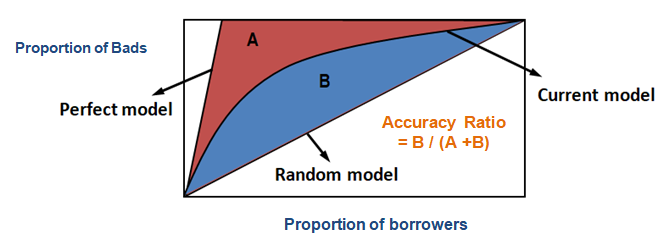

In [7]:
Image(filename='figs/CAP.png')

To make this more concrete, let's define 
- $Y_i \in \left\lbrace 0, 1 \right\rbrace$: the *observed* classlabel for observation $i$;
- $S_i \in \left( 0, 1 \right)$: the *predicted* probability for $i$ to belong to class $1$;

then we have
\begin{equation}
F(x) = P(S_i \geq 1 - x ), \hspace{15pt} G(x) = P( S_i \geq 1-x \hspace{2pt} | \hspace{2pt} Y_i = 1), \hspace{15pt} \text{CAP} (x) = G \left[ F(x) \right].
\end{equation}

So, $F(x)$ is constructed based on *all* observations $i$, $(Y_i = 0,1)$, whereas $G(x)$ is constructed based on those $i$ where $Y_i = 1$. The CAP is simply obtained by plotting $F(x)$ vs $G(x)$. 

The code example below implements and plots the CAP curve. As far as I know, there is no library implementing this, so we cannot compare to that.

In [8]:
# observed data & predictions
Y = np.array([1, 0, 0, 1, 1] )
S = np.array( [0.1, 0.6, 0.3, 0.9, 0.7] )

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


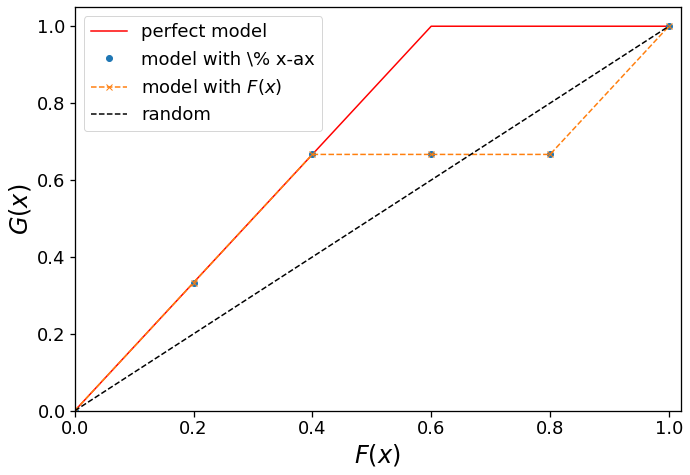

In [9]:
# perfect classification
pct_positive = np.sum(Y) / len(Y)
perfect = pd.DataFrame({'x':[0, pct_positive ,1],'y':[0,1,1]})


# find subset of positive observations
idx = np.where(Y == 1)[0]
S_1 = S[idx]


# create x-space; in principle, we should use a finegrained axis x = np.arange(0, 1, ["a lot of steps"])
#                 however, F and G only change when one of (sorted) S-values is crossed.
#                 so, the definition below is sufficient and more selfcontained.
x = S[ S.argsort() ]
x_min = x[::-1]
x_min = np.append(x_min, [0])

# compute F and G
F = np.zeros(len(x_min))
G = np.zeros(len(x_min))
for i in range(len(x_min)):
    F[i] = 1/len(S) * len( np.where( S > x_min[i])[0] )
    G[i] = 1/len(S_1) * len( np.where( S_1 > x_min[i])[0] )


# % of observations on x-axis for comparison with F(x)
xx = np.arange( len(Y)+1) / float(len(Y) )

# plot F and G
fig, ax = plt.subplots()
ax.plot(perfect['x'], perfect['y'], 'r', label='perfect model')
ax.plot(xx, G, 'o', label=r'model with \% x-ax')
ax.plot(F, G, 'x--', label=r'model with $F(x)$')
ax.plot(F, F, 'k--', label=r'random')

ax.set_xlabel(r'$F(x)$')
ax.set_ylabel(r'$G(x)$')
ax.set_xlim(0, 1.02)
ax.set_ylim(0, 1.05)
ax.legend()
plt.show()


Some notes:
- Although not completely obvious, $F(x)$ is just the percentage of observations considered. To make this explicit, I've plotted both $F(x)$ as computed through the formal definition, as $xx$, which is simply a np.arange().
- A perfect model is always given by the linesegments $[ (0,0), (p,1), (1,1) ]$, where $p$ is the fraction of positive outcomes.
- As a result, the true area-between-the-curves is computed by dividing area $A$ (model curve) by area $A+B$ (perfect curve), as shown in the example above.
- This is fundamentally different from the ROC curve, where a perfect model is characterized by the linesegments $[ (0,0), (1,1), (1,1) ]$, and the area $A+B$ always equals $1/2$ and thus does not need to be computed.
- Although it doesn't ofter happen for larger datasets, the model can (partially) be worse than random. In this case, the modelcurve dives below the random curve. The area between this part of the modelcurve and randomcurve counts as 'negative' area.
- This computation of $F(x)$ and $G(x)$ is very inefficient as it is not vectorized; see below for the vectorization.

#### Compute Area Between Curves (aka Accuracy Ratio)

The model, perfect model and normalized area-between-the-curves is simply computed by taking the piecewise sum of area-elements:
\begin{equation}
A_m = \sum_i \frac{1}{2} \left( G_{i+1} - G_i \right)\left( F_{i+1} - F_i \right) - \frac{1}{2}, \hspace{20pt}
A_{pm} = (1-p) + \frac{p}{2} - \frac{1}{2} = \frac{1}{2}(1-p) , \hspace{20pt}
A_\text{norm}  = \frac{A_m}{A_{pm} }
\end{equation}

In [10]:
# compute areas
ABC_model =   np.sum(  0.5 * ( (np.roll(G,1) + G)[1::] * (F - np.roll(F,1) )[1::]  ) ) - 0.5
ABC_perfect = (  0.5* (perfect.x[1] - perfect.x[0]) * (perfect.y[1] + perfect.y[0]) + (perfect.x[2] - perfect.x[1]) * perfect.y[2] ) - 0.5 
ABC_norm = ABC_model / ABC_perfect 

# print results
print("Perfect model: " + str(ABC_perfect))
print("Our unnormalized model: " + str(ABC_model))
print("Our normalized model: " + str(ABC_norm))

Perfect model: 0.19999999999999996
Our unnormalized model: 0.06666666666666665
Our normalized model: 0.3333333333333333


## ROC

The Receiver Operating Characteristic is very similar to the CAP curve. It is created by plotting the True Positive Rate (TPR) as function of the False Positive Rate (FPR). These are defined as
\begin{equation}
TPR(x) = \frac{TP(x)}{\text{total } P} = \frac{TP(x)}{TP(x) + FN(x)}, \hspace{20pt} FPR(x) = \frac{FP(x)}{\text{total } F} = \frac{FP(x)}{FP(x) + TN(x)},
\end{equation}

where $TP(x)$ ($FP(x)$) is defined as the number of correctly (falsely) classified positives (label "1") at threshold $x$. The threshold $x$ determines with what confidence we classify an observation as positive. I.e., the we predict observation $i$ to be positive if $S_i > x$. (Typically, a classifier has $x = 0.5$.)

The ROC and CAP are quite similar, which can be made explicit by noting that

\begin{equation}
TPR(x) = P( S_i \geq 1-x \hspace{2pt} | \hspace{2pt} Y_i = 1), \hspace{10pt} \text{and} \hspace{10pt} FPR(x) = P( S_i \geq 1-x \hspace{2pt} | \hspace{2pt} Y_i = 0).
\end{equation}<br>
As such, the ROC and CAP have the same y-axes and a different - albeit similar - x-axes. It can be shown that the following holds

\begin{equation}
\text{CAP ABC} = \text{AR} = \text{Gini} = 2 \text{ROC AUC} - 1.
\end{equation}

The proof of this relation is not trivial. It can (e.g.) be found in Englemann, B., E. Hayden, and D. Tasche, 2003, which is freely available at https://www.researchgate.net/publication/215991100_Testing_Rating_Accuracy.

Intuitively, the ROC-curve measures the percentage of rightly classified positives versus the percentage of wrongly classified positives. The figure below provides an example. Note that:
- The perfect model has area-under-the-curve = 1;
- Therefore, normalizing is pointless;

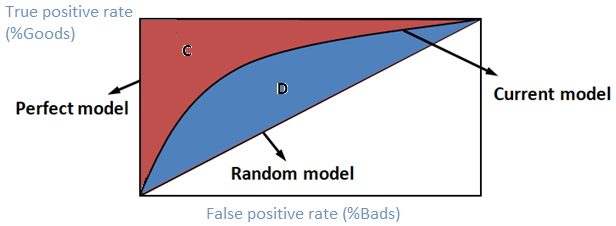

In [11]:
Image(filename='figs/ROC.png')

The code snippet below implements the ROC-curve.

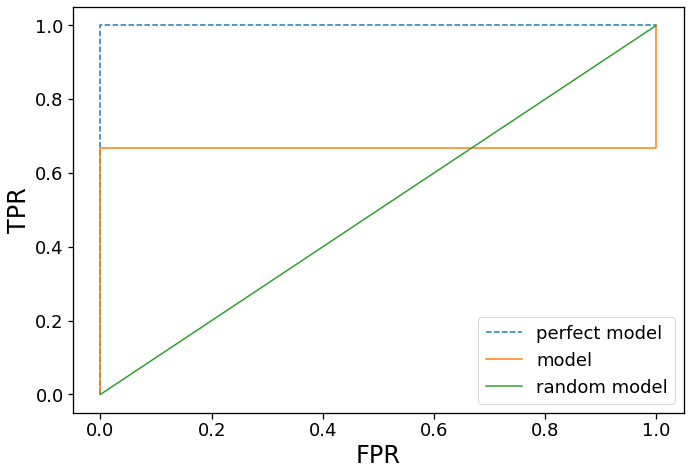

In [12]:
# create array containing classifying thresholds
# if the threshold x = 0.1, it means that we classify any observation with prob(i=1) > 0.1 as a "1"
# since the only meaningful thresholds are given by S, we can take that as our thresholds 
# we have to append a "0" at the end though
x = S[ S.argsort() ]
x_min = x[::-1]              # compute the reverse so that the fpr / tpr is ascending.
x_min = np.append(x_min, [0])


# compute TP and RP at various thresholds
FP = np.zeros(len(x_min))
TP = np.zeros(len(x_min))
for i in range(len(x_min)):
    pred = np.double(S > x_min[i])  # double creates a double precision float, we misuse it as a round function with threshold
    
    for j in range(len(pred)):
        if pred[j] == 1 and Y[j] == 1:
            TP[i] += 1                     # count nr of true positives at threshold i by looping over the labels
        elif pred[j] == 1 and Y[j] == 0:
            FP[i] += 1                     # same for false negatives

# compute total positives and negatives
total_pos = np.sum(Y)
total_neg = len(Y) - np.sum(Y)

# compute 'rates'
FPR = FP / total_neg        # aka "Type 1 error" rate --> TPR = TP / (TP + FN)
TPR = TP / total_pos        # aka "hit" rate          --> FPR = FP / (FP + TN)


# plot results
# note: perfect model shoots up to 1 immediatly. there are no false classifications.
fig, ax = plt.subplots()
ax.plot([0, 0, 1], [0, 1, 1], '--', label=r'perfect model')
ax.plot(FPR, TPR, label='model')
ax.plot(TPR, TPR, label='random model')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()
plt.show()

##### Check with scikit-learn

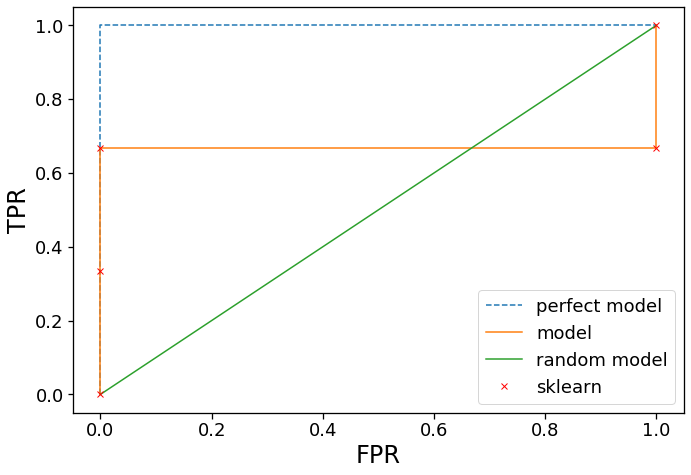

In [13]:
# do the same computations via sklearn to compare
from sklearn.metrics import roc_curve 

fpr, tpr, _ = roc_curve(Y, S)

fig, ax = plt.subplots()
ax.plot([0, 0, 1], [0, 1, 1], '--', label=r'perfect model')
ax.plot(FPR, TPR, label='model')
ax.plot(TPR, TPR, label='random model')
ax.plot(fpr, tpr, 'rx', label='sklearn')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()


#### Compute Area Under Curve

We compute the area between the curves in the same way:

In [14]:
# Compute areas under the curve
ROC_AUC_model =   np.sum(  0.5 * ( (np.roll(tpr,1) + tpr)[1::] * (fpr - np.roll(fpr,1) )[1::]  ) ) 
ROC_AUC_perfect = 1


# print results
print("Perfect ROC AUC: " + str(ROC_AUC_perfect))
print("Model ROC AUC: " + str(ROC_AUC_model))
print("Model Gini: " + str(2*ROC_AUC_model - 1))


# check with sklearn
from sklearn.metrics import roc_auc_score
Gini = 2*roc_auc_score(Y, S) -1

print("Sk-learn Gini: " + str(Gini))

Perfect ROC AUC: 1
Model ROC AUC: 0.6666666666666666
Model Gini: 0.33333333333333326
Sk-learn Gini: 0.33333333333333326


## Note on CAP / Powercurve / Lorenz Curve / ROC and AUC / ABC / Gini / Powerstat / etc.

As far as I understand, the concept of the CAP-curve is also referred to as "Powercurve" or "Lorenz-curve" (although in this case the axes are sometimes switched (how nice)). However, the ROC-curve is really something different.

Which one is used when?
- short answer: I don't know;
- longer answer: https://www.imf.org/external/pubs/ft/wp/2012/wp12122.pdf.

## Vectorized implementation

For large datasets, vectorized implemenations are much faster.

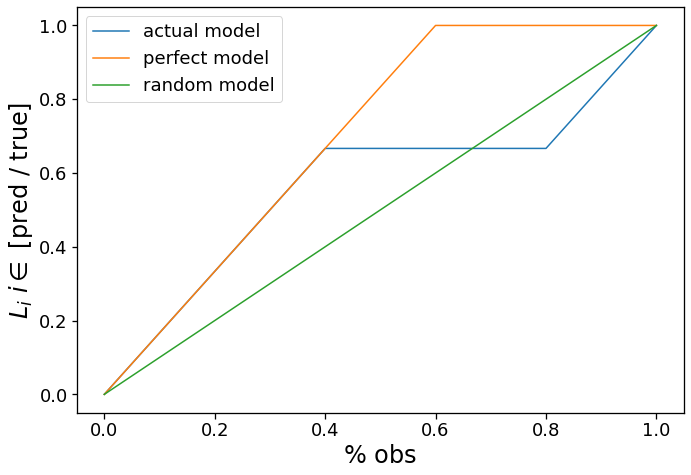

Model ABC: 0.33333333333333304
Perfect ABC: 0.9999999999999998
Gini = Model ABC / Perfect ABC: 0.3333333333333331


In [15]:
# check and get number of samples
assert Y.shape == S.shape
n_samples = Y.shape[0]

# sort rows on prediction column 
# (from largest to smallest)
arr = np.array([Y, S]).transpose()
true_order = arr[arr[:,0].argsort()][::-1,0]
pred_order = arr[arr[:,1].argsort()][::-1,0]
    
# get Lorenz curves
L_true = np.cumsum(true_order) / np.sum(true_order)
L_true = np.insert(L_true, 0, 0)
L_pred = np.cumsum(pred_order) / np.sum(pred_order)
L_pred = np.insert(L_pred, 0, 0)
L_ones = np.linspace(0, 1, n_samples+1)
    
# get Gini coefficients (area between curves)
G_true = np.sum(L_true - L_ones)
G_pred = np.sum(L_pred - L_ones)
G_norm = G_pred / G_true  

# plot figs
fig, ax = plt.subplots()
ax.plot( np.linspace(0, 1, len(L_pred)), L_pred, label='actual model')
ax.plot( np.linspace(0, 1, len(L_pred)), L_true, label='perfect model')
ax.plot( np.linspace(0,1,len(L_pred)), L_ones, label='random model')
ax.set_xlabel(r'$\%$ obs')
ax.set_ylabel(r'$L_{i}$ $i\in $ [pred / true]')
ax.legend()
plt.show()

print("Model ABC: " + str(G_pred))
print("Perfect ABC: " + str(G_true))
print("Gini = Model ABC / Perfect ABC: " + str(G_norm))

## Significance
#### Analytical confidence interval

Since the Gini coefficient is the sample mean of independent identically distributed random variables, by the central limit theorem it follows that that it is asymptotically normally distributed. Given a significance level $\alpha$, the confidence interval can be computed as

\begin{equation}
\left( G - s_G \Phi^{-1} \left( 1 - \frac{\alpha}{2} \right), \hspace{3pt} G + s_G \Phi^{-1} \left( 1 - \frac{\alpha}{2} \right) \right),
\end{equation}

where $s_G$ is the sample standard deviation and $\Phi$ the normal distribution. When testing the null hypothesis that the Gini equals $0$, it is given as

\begin{equation}
s_G^2 = \frac{N+1}{3N_0N_1},
\end{equation}
where $N$ is the total number of observations and $N_{0 (1)}$ is the number of observations with outcome $0$ ($1$). (correct?)

In [30]:
# basic params
N = len(Y)
N1 = np.sum(Y)
N0 = N - N1

# compute std deviation
s = np.sqrt( (N+1)/(3*N0*N1) )

# compute cv from normal distribution
from scipy.stats import norm
alpha = 0.05
cv = norm.cdf(1-alpha/2)

# compute confidence interval
CI_low = G_norm - s*cv/np.sqrt(N)
CI_up = G_norm + s*cv/np.sqrt(N)

print("Confidence interval: (" + str(np.round(CI_low, 2)) + ', ' + str(np.round(CI_up, 2)) + ')')
print("Gini found: " + str(G_norm))


Confidence interval: (0.12, 0.55)
Gini found: 0.3333333333333331


#### Bootstrapped confidence interval

Not working yet.

In [55]:
# generate some fake data
N = 100
S = np.round(np.random.rand(N), 1)
Y_hat = np.round(S)

rand_idx = np.round( np.random.rand(np.int(N/5))*N).astype(int)
Y = Y_hat.copy()
for i in rand_idx:
    if Y[i] == 1.:
        Y[i] = 0.
    else:
        Y[i] = 1.

In [56]:
n_iter = 1000
Gini_boots = []

# it is late and I'm gonna cheat by utilising scikit for computing the Gini
from sklearn.metrics import roc_auc_score
for i in range(n_iter):
    idx = (np.random.rand(N)*5).astype(int)
    Y_boots = Y[idx]
    S_boots = S[idx]
    Gini = 2*roc_auc_score(Y_boots, S_boots) -1
    Gini_boots.append(Gini)    

In [59]:
# extract percentiles
def confidence_interval(sim, alpha):
    """
    Return 2-sided symmetric confidence interval specified
    by p.
    """
    n = len(sim)
    u_pval = 1 - alpha/2
    l_pval = alpha / 2
    l_idx = int(np.floor(n*l_pval))
    u_idx = int(np.floor(n*u_pval))
    return(sim[l_idx], sim[u_idx])

bounds = confidence_interval(Gini_boots, alpha=0.05)

print("Analytical confidence interval: (" + str(np.round(CI_low, 2)) + ', ' + str(np.round(CI_up, 2)) + ')')
print("Bootstrapped confidence interval: (" + str(np.round(bounds[0], 2)) + ', ' + str(np.round(bounds[1], 2)) + ')')
print("Gini found: " + str(G_norm))

Analytical confidence interval: (0.12, 0.55)
Bootstrapped confidence interval: (0.1, -0.17)
Gini found: 0.3333333333333331
